In [0]:
# import warnings
# warnings.filterwarnings('ignore',category=UserWarning)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !apt-get install p7zip-full
# !tar -xvf ../epfl_lab.tar

In [0]:
# %cd ..

In [0]:
# !unzip lightnet-master.zip

In [0]:
# !python "example/bin/train.py" -c -n "example/cfg/yolo.py"

In [0]:
# sudo !pip uninstall lightnet
# !sudo python setup.py install

Install packages.

In [0]:
# !pip install visdom
# !pip uninstall lightnet
# !pip install git+https://gitlab.com/eavise/lightnet
# !pip install brambox
# !pip install dataset

In [1]:
%cd lightnet-master/
!ls

/content/lightnet-master
code-test.py			 lab_826_confidence_rgb.csv
darknet19_448.conv.23.pt	 lab_890_confidence_rgb.csv
data				 lab_890_confidence_rgbd.csv
develop.txt			 lab_948_confidence_rgb.csv
docs				 lab_948_confidence_rgbd.csv
epfl_lab			 lab_95_confidence.csv
example				 LICENSE
lab_397_confidence_rgbd.csv	 lightnet
lab_465_confidence_rgbd.csv	 MANIFEST.in
lab_642_confidence_rgbd.csv	 README.md
lab_740_0.3_confidence_rgbd.csv  setup.py
lab_740_0.4_confidence_rgbd.csv  test
lab_826_confidence.csv		 VERSION


In [2]:
#!/usr/bin/env python
import os
import os
cwd = os.getcwd()
print(cwd)
import logging
import time
import argparse
from math import isinf
from statistics import mean
import torch
# import visdom
import numpy as np
import lightnet as ln
# from dataset import *


from example.bin.dataset import VOCDataset

log = logging.getLogger('lightnet.VOC.train')


class TrainEngine(ln.engine.Engine):
    def start(self):
        self.params.to(self.device)
        self.dataloader.change_input_dim()
        self.optimizer.step()
        # self.optimizer.step(self.batch)     # Needed when resuming, harmless with batch=0
        self.optimizer.zero_grad()

        self.train_loss = {'tot': [], 'coord': [], 'conf': [], 'cls': []}
        self.plot_train_loss = ln.engine.LinePlotter(self.visdom, 'train_loss', opts=dict(xlabel='Batch', ylabel='Loss', title='Training Loss', showlegend=True, legend=['Total loss', 'Coordinate loss', 'Confidence loss', 'Class loss']))
        self.plot_lr = ln.engine.LinePlotter(self.visdom, 'learning_rate', name='Learning Rate', opts=dict(xlabel='Batch', ylabel='Learning Rate', title='Learning Rate Schedule'))
        self.batch_end(self.plot_rate)(self.plot)

    def process_batch(self, data):
        data, target = data
        data = data.to(self.device)

        # print(data.size(1))
        out = self.network(data)
        loss = self.loss(out, target) / self.batch_subdivisions
        loss.backward()

        self.train_loss['tot'].append(self.loss.loss_tot.item())
        self.train_loss['coord'].append(self.loss.loss_coord.item())
        self.train_loss['conf'].append(self.loss.loss_conf.item())
        self.train_loss['cls'].append(self.loss.loss_cls.item())

    def train_batch(self):
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.scheduler.step(self.batch, epoch=self.batch)

        # Get values from last batch
        tot = mean(self.train_loss['tot'][-self.batch_subdivisions:])
        coord = mean(self.train_loss['coord'][-self.batch_subdivisions:])
        conf = mean(self.train_loss['conf'][-self.batch_subdivisions:])
        cls = mean(self.train_loss['cls'][-self.batch_subdivisions:])
        self.log(f'{self.batch} Loss:{tot:.5f} (Coord:{coord:.2f} Conf:{conf:.2f} Cls:{cls:.2f})')

        if isinf(tot):
            log.error('Infinite loss')
            self.sigint = True
            return

    def plot(self):
        tot = mean(self.train_loss['tot'])
        coord = mean(self.train_loss['coord'])
        conf = mean(self.train_loss['conf'])
        cls = mean(self.train_loss['cls'])
        self.train_loss = {'tot': [], 'coord': [], 'conf': [], 'cls': []}

        self.plot_train_loss(np.array([[tot, coord, conf, cls]]), np.array([self.batch]))
        self.plot_lr(np.array([self.optimizer.param_groups[0]['lr']]), np.array([self.batch]))

    @ln.engine.Engine.batch_end(500)
    def backup(self):
        self.params.save(os.path.join(self.backup_folder, f'weights_{self.batch}.state.pt'))
        log.info(f'Saved backup')

    @ln.engine.Engine.batch_end(10)
    def resize(self):
        self.dataloader.change_input_dim()

    def quit(self):
        if self.batch >= self.max_batches:
            self.params.network.save(os.path.join(self.backup_folder, 'final.pt'))
            return True
        elif self.sigint:
            self.params.save(os.path.join(self.backup_folder, 'backup.state.pt'))
            return True
        else:
            return False


/content/lightnet-master


In [0]:
weight = None

# Parse arguments
device = torch.device('cpu')
if True:
    if torch.cuda.is_available():
        log.debug('CUDA enabled')
        device = torch.device('cuda')
    else:
        log.error('CUDA not available')


params = ln.engine.HyperParameters.from_file("example/cfg/yolo.py")
if weight is not None:
    if weight.endswith('.state.pt'):
        params.load(args.weight)
    else:
        params.network.load(weight, strict=False)  # Disable strict mode for loading partial weights

# Dataloader
training_loader = ln.data.DataLoader(
    VOCDataset(os.path.join("data/", params.train_set), params, True),
    batch_size = params.mini_batch_size,
    shuffle = True,
    drop_last = True,
    num_workers = 8,
    pin_memory = True,
    collate_fn = ln.data.brambox_collate,
)

# Start training
eng = TrainEngine(
    params, training_loader,
    device=device, visdom=None, plot_rate=1, backup_folder="example/bin/backup_rgbd"
)
b1 = eng.batch
t1 = time.time()
eng()
t2 = time.time()
b2 = eng.batch
log.info(f'Training {b2-b1} batches took {t2-t1:.2f} seconds [{(t2-t1)/(b2-b1):.3f} sec/batch]')

WARNING    [brambox.io.parser.box._pandas] No 'pd_format' argument found, inferring format from file extension
INFO       Start training
INFO       Resizing network (512, 512)
TRAIN      1 Loss:322.84006 (Coord:147.17 Conf:175.67 Cls:0.00)
TRAIN      2 Loss:2086.60233 (Coord:2084.01 Conf:2.60 Cls:0.00)
TRAIN      3 Loss:2057.73129 (Coord:2055.11 Conf:2.62 Cls:0.00)
TRAIN      4 Loss:2056.44536 (Coord:2053.85 Conf:2.60 Cls:0.00)
TRAIN      5 Loss:2059.85330 (Coord:2057.19 Conf:2.67 Cls:0.00)
TRAIN      6 Loss:2057.82887 (Coord:2055.25 Conf:2.57 Cls:0.00)
TRAIN      7 Loss:1974.65611 (Coord:1972.07 Conf:2.58 Cls:0.00)
TRAIN      8 Loss:2099.32617 (Coord:2096.69 Conf:2.64 Cls:0.00)
TRAIN      9 Loss:2044.67567 (Coord:2042.07 Conf:2.61 Cls:0.00)
TRAIN      10 Loss:2067.03436 (Coord:2064.43 Conf:2.61 Cls:0.00)
INFO       Resizing network (320, 320)
TRAIN      11 Loss:2041.78329 (Coord:2039.13 Conf:2.65 Cls:0.00)
TRAIN      12 Loss:2091.29037 (Coord:2088.72 Conf:2.57 Cls:0.00)
TRAIN      13 

Testing

In [0]:
#!/usr/bin/env python
import os
import argparse
import logging
from statistics import mean
import torch
from PIL import Image
import pandas as pd
from tqdm import tqdm
import lightnet as ln
import brambox as bb
# from dataset import *

log = logging.getLogger('lightnet.VOC.test')


class TestEngine:
    def __init__(self, params, dataloader, **kwargs):
        self.params = params
        self.dataloader = dataloader

        # extract data from params
        self.post = params.post
        self.loss = params.loss
        self.network = params.network

        # Setting kwargs
        for k, v in kwargs.items():
            if not hasattr(self, k):
                setattr(self, k, v)
            else:
                log.error('{k} attribute already exists on TestEngine, not overwriting with `{v}`')

    def __call__(self):
        self.params.to(self.device)
        self.network.eval()
        self.loss.eval()    # This is necessary so the loss doesnt use its 'prefill' rule

        if self.loss_format == 'none':
            anno, det = self.test_none()
        else:
            anno, det = self.test_loss()

        aps = []
        for c in tqdm(self.params.class_label_map):
            anno_c = anno[anno.class_label == c]
            det_c = det[det.class_label == c]

            # By default brambox considers ignored annos as regions -> we want to consider them as annos still
            matched_det = bb.stat.match_det(det_c, anno_c, 0.5, criteria=bb.stat.coordinates.iou, ignore=bb.stat.IgnoreMethod.SINGLE)
            pr = bb.stat.pr(matched_det, anno_c)

            aps.append(bb.stat.ap(pr))

        m_ap = round(100 * mean(aps), 2)
        print(f'mAP: {m_ap:.2f}%')

        if self.detection is not None:
            def get_img_dim(name):
                with Image.open(f'epfl_lab/20140804_160621_00/{name}') as img:
                    return img.size

            rlb = ln.data.transform.ReverseLetterbox(self.params.input_dimension, get_img_dim)
            det = rlb(det)
            bb.io.save(det, 'pandas', self.detection)

    def test_none(self):
        anno, det = [], []

        with torch.no_grad():
            for idx, (data, target) in enumerate(tqdm(self.dataloader)):
                data = data.to(self.device)
                output = self.network(data)
                output = self.post(output)

                output.image = pd.Categorical.from_codes(output.image, dtype=target.image.dtype)
                anno.append(target)
                det.append(output)

        anno = bb.util.concat(anno, ignore_index=True, sort=False)
        det = bb.util.concat(det, ignore_index=True, sort=False)
        return anno, det

    def test_loss(self):
        loss_dict = {'tot': [], 'coord': [], 'conf': [], 'cls': []}
        anno, det = [], []

        with torch.no_grad():
            for idx, (data, target) in enumerate(tqdm(self.dataloader)):
                data = data.to(self.device)
                output = self.network(data)
                loss = self.loss(output, target)
                output = self.post(output)

                num_img = data.shape[0]
                loss_dict['tot'].append(self.loss.loss_tot.item() * num_img)
                loss_dict['coord'].append(self.loss.loss_coord.item() * num_img)
                loss_dict['conf'].append(self.loss.loss_conf.item() * num_img)
                loss_dict['cls'].append(self.loss.loss_cls.item() * num_img)

                output.image = pd.Categorical.from_codes(output.image, dtype=target.image.dtype)
                anno.append(target)
                det.append(output)

        anno = bb.util.concat(anno, ignore_index=True, sort=False)
        det = bb.util.concat(det, ignore_index=True, sort=False)

        loss_tot = sum(loss_dict['tot']) / len(anno.image.cat.categories)
        loss_coord = sum(loss_dict['coord']) / len(anno.image.cat.categories)
        loss_conf = sum(loss_dict['conf']) / len(anno.image.cat.categories)
        loss_cls = sum(loss_dict['cls']) / len(anno.image.cat.categories)
        if self.loss == 'percent':
            loss_coord *= 100 / loss_tot
            loss_conf *= 100 / loss_tot
            loss_cls *= 100 / loss_tot
            log.info(f'Loss:{loss_tot:.5f} (Coord:{loss_coord:.2f}% Conf:{loss_conf:.2f}% Class:{loss_cls:.2f}%)')
        else:
            log.info(f'Loss:{loss_tot:.5f} (Coord:{loss_coord:.2f} Conf:{loss_conf:.2f} Class:{loss_cls:.2f})')

        return anno, det




In [22]:
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(
#         description='Test trained network',
#         formatter_class=argparse.ArgumentDefaultsHelpFormatter
#     )
#     parser.add_argument('weight', help='Path to weight file')
#     parser.add_argument('-n', '--network', help='network config file', required=True)
#     parser.add_argument('-c', '--cuda', action='store_true', help='Use cuda')
#     parser.add_argument('-t', '--thresh', help='Detection Threshold', type=float, default=None)
#     parser.add_argument('-l', '--loss', help='How to display loss', choices=['abs', 'percent', 'none'], default='abs')
#     parser.add_argument('-a', '--anno', help='annotation folder', default='./data')
#     parser.add_argument('-d', '--det', help='Detection pandas file', default=None)
#     args = parser.parse_args()

# Parse arguments
device = torch.device('cpu')
if True:
    if torch.cuda.is_available():
        log.debug('CUDA enabled')
        device = torch.device('cuda')
    else:
        log.error('CUDA not available')

params = ln.engine.HyperParameters.from_file("example/cfg/yolo.py")


weight = "../lab_rgb_weights_1800.state.pt"

if weight.endswith('.state.pt'):
    params.load(weight)
else:
    params.network.load(weight)
    
thresh = 0.30

if thresh is not None: # Overwrite threshold
    params.post[0].conf_thresh = thresh

# Dataloader
testing_dataloader = torch.utils.data.DataLoader(
    VOCDataset(os.path.join("data/", params.test_set), params, False),
    batch_size = params.mini_batch_size,
    shuffle = False,
    drop_last = False,
    num_workers = 8,
    pin_memory = True,
    collate_fn = ln.data.brambox_collate,
)

# Start test
eng = TestEngine(
    params, testing_dataloader,
    device=device,
    loss_format="abs",
    detection="data/result.h5",
)
eng()


INFO       Loading state from file [../lab_rgb_weights_1800.state.pt]
WARNING    [brambox.io.parser.box._pandas] No 'pd_format' argument found, inferring format from file extension
100%|██████████| 21/21 [00:07<00:00,  5.45it/s]
INFO       Loss:0.32499 (Coord:0.11 Conf:0.21 Class:0.00)
100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


mAP: 94.80%


WARNING    [brambox.io.parser.box._pandas] No 'pd_format' argument found, inferring format from file extension


In [0]:
# %debug

In [0]:
import pandas as pd
reread = pd.read_hdf('data/result.h5')

In [6]:
reread[(reread.class_label=="person") & (reread.image=="rgb000397.png")]

,image,class_label,id,x_top_left,y_top_left,width,height,confidence
117,rgb000397.png,person,NaN,335.702449,91.485953,51.793222,188.110314,0.840612
118,rgb000397.png,person,NaN,214.261794,107.225802,59.184782,182.997540,0.718756
119,rgb000397.png,person,NaN,311.319186,93.587177,63.745267,257.592398,0.868740
120,rgb000397.png,person,NaN,140.929284,113.378042,98.942439,260.827937,0.876423


In [0]:
from PIL import Image


from PIL import Image, ImageFont, ImageDraw, ImageEnhance

image_name = "rgb000826.png"
source_img = Image.open("epfl_lab/20140804_160621_00/{}".format(image_name)).convert("RGBA")
# source_img = source_img.resize((416, 416), Image.ANTIALIAS)
draw = ImageDraw.Draw(source_img)

sub_df =  reread[(reread.class_label=="person") & (reread.image==image_name)]
for _,i in sub_df.iterrows():
  x,y,w,h = i["x_top_left"],i["y_top_left"],i["width"],i["height"]
  draw.rectangle(((x, y), (x+w, y+h)), outline="red")

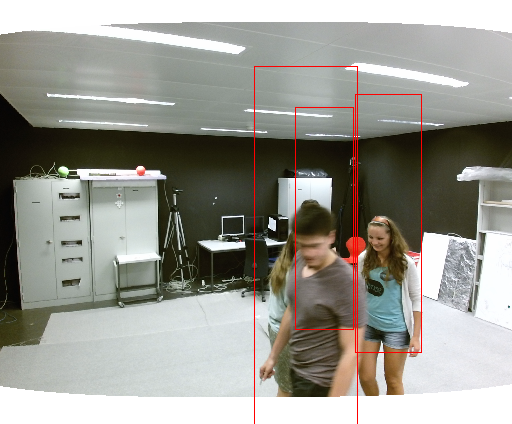

In [24]:
source_img

In [0]:
sub_df.to_csv("lab_826_confidence_rgb.csv")
source_img.save("../drive/My Drive/lab_826_rgb.png") ## 0.4 threshold

In [0]:
## Results : 826, 890, 948, 740(0.3,0.4),465, 397

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
